In [1]:
import os, sys
import re
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /jobfs/137341584.gadi-pbs/matplotlib-4sutpuaq because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [3]:
from dask.distributed import Client, wait
client = Client(n_workers=50, threads_per_worker=1, memory_limit=None)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 50
Total threads: 50,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45087,Workers: 50
Dashboard: /proxy/8787/status,Total threads: 50
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45649,Total threads: 1
Dashboard: /proxy/42999/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43755,


2025-03-21 10:07:40,259 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33223'.


# NASA GISS TEMP

In [4]:
GISS_PATH = '/g/data/w40/ab2313/time_of_emergence/gistemp1200_GHCNv4_ERSSTv5.zarr'

In [5]:
ds = xr.open_dataset(GISS_PATH, engine='zarr')

In [7]:
ds = ds.tempanomaly

In [15]:
ds = ds.resample(time='YE').mean().persist()
wait(ds);

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


In [16]:
ds

<xarray.DataArray 'tempanomaly' (time: 146, lat: 90, lon: 180)> Size: 9MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 3.9208333 ,  3.9208333 ,  3.9208333 , ...,  3.9208333 ,
          3.9208333 ,  3.9208333 ],
        [ 3.9208333 ,  3.9208333 ,  3.9208333 , ...,  3.9208333 ,
          3.9208333 ,  3.9208333 ],
        [ 3.9208333 ,  3.9208333 ,  3.9208333 , ...,  3.9208333 ,
          3.9208333 ,  3.9208333 ]],

       [[ 0.32      ,  0.32      ,  0.32      , ...,  0.32      ,
          0.32      ,  0.32      ],
        [ 0.32      ,  0.32      ,  0.32      , ...,  0.32      ,
          0.32      ,  0.32      ],
        [ 0.32      ,  0.32      ,  0.32      , ...,  0.32      ,
          0.32      ,  0.32      ],
        ...,
        [ 7.4849997 ,  7.4849997 ,  7.4849997 , ...,  7.4849997 ,
          7.4849997 ,  7.4849997 ],
        [ 7.4849997 ,  7.4849997 ,  7.4849997 , ...,  7.4849997 ,
          7.4849997 ,  7.4849997 ],
        [ 7.4849997 ,  7.4849997 ,  7.4849997 , ...,  7.4849997 ,
          7.4849997 ,  7.4849997 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 1kB 1880-12-31 1881-12-31 ... 2025-12-31
Attributes:
    cell_methods:  time: mean
    long_name:     Surface temperature anomaly
    units:         K

In [18]:
np.take(ds.time.values, [0, 1,2, -3, -2, -1])

array(['1880-12-31T00:00:00.000000000', '1881-12-31T00:00:00.000000000',
       '1882-12-31T00:00:00.000000000', '2023-12-31T00:00:00.000000000',
       '2024-12-31T00:00:00.000000000', '2025-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [28]:
# ds_base = ds.sel(time=slice('1880', '1909'))
# ds_base = ds.sel(time=slice('1900', '1929'))
ds_base = ds.sel(time=slice('1900', '1969'))

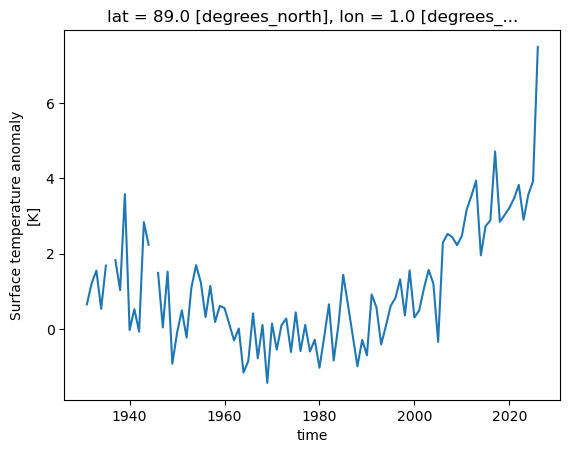

2025-03-21 10:07:40,266 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


In [30]:
ds.sel(lat=90, lon=0, method='nearest').plot()

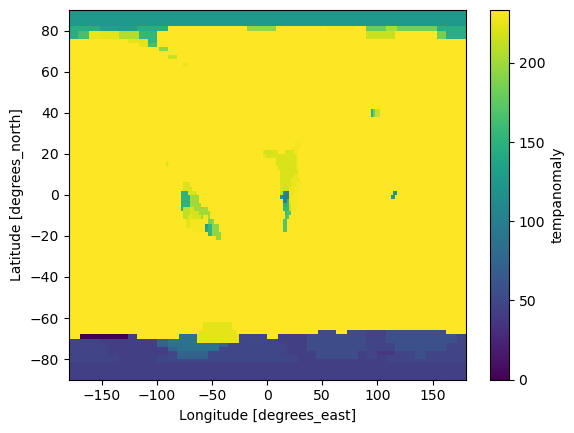

In [29]:
(ds_base.count(dim='time')*100/30).plot()

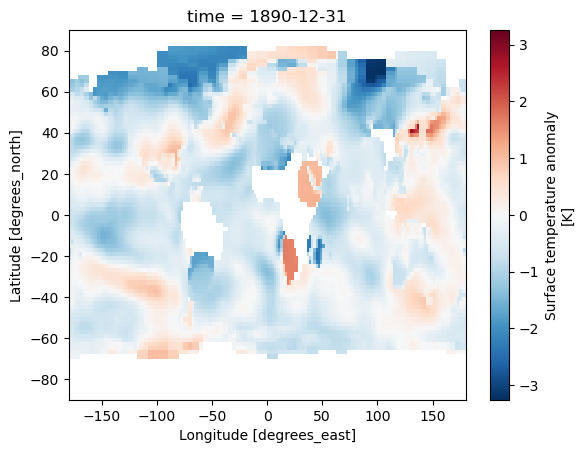

In [19]:
ds.isel(time=10).plot()

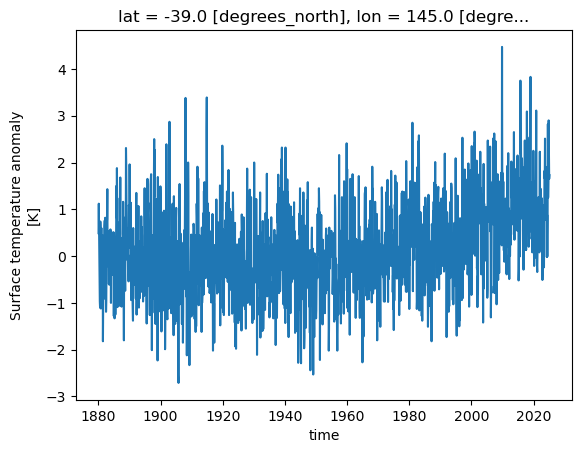

In [11]:
ds.sel(lat=-39, lon=145, method='nearest').plot()

# Large Esembles (LEs)

In [4]:
variable = 'pr' # tas

In [5]:
ACCESS_PATH = f'/g/data/v45/nxm561/access_lens/Amon/{variable}'

In [6]:
# ACCESS_HIST_PATH = os.path.join(ACCESS_PATH, 'tas_ACCESS-ESM1-5_hist_*_185001-201412.nc'

In [7]:
ACCESS_SSP_585_PATH = f'/g/data/v45/nxm561/access_lens/Amon/{variable}/{variable}_mon_ACCESS-ESM1-5_ssp585_*_g025.nc'

In [8]:
access_paths = np.array(os.listdir(ACCESS_PATH))
access_paths.shape

(410,)

In [9]:
access_ssp585_paths = np.array(list(filter(lambda x: ('ssp585' in x) and ('mon' not in x), access_paths)))
access_ssp585_paths.shape

(40,)

In [10]:
access_hist_paths = np.array(list(filter(lambda x: ('hist' in x) and ('mon' not in x), access_paths)))
access_hist_paths.shape

(40,)

In [11]:
def extract_member(filename):
    # Regex to extract ensemble member (e.g., r21i1p1)
    match = re.search(r'r\d+i\d+p\d+', filename)
    return match.group(0) if match else None

def open_all_ensembles(file_paths, variable='tas'):
    # Open datasets individually, add member coordinate, and store them in a list
    ds_list = []
    for file in file_paths:
        member = extract_member(file)
        ds = xr.open_dataset(file) #, chunks='auto')#={'time':-1, 'lon':144//12, 'lat':72//12})
        ds = ds.assign_coords(member=member).expand_dims('member')
        ds_list.append(ds[variable])

    # Concatenate along the 'member' dimension
    ds_combined = xr.concat(ds_list, dim='member').chunk(
        {'member': 1, 'time':-1, 'lon':144//12, 'lat':72//12})
    return ds_combined

In [12]:
# Full paths
hist_file_paths = [os.path.join(ACCESS_PATH, f) for f in access_hist_paths]
spp585_file_paths = [os.path.join(ACCESS_PATH, f) for f in access_ssp585_paths]

In [13]:
hist_raw_ds = open_all_ensembles(hist_file_paths, variable)
ssp585_raw_ds = open_all_ensembles(spp585_file_paths, variable)

In [14]:
days_per_month_hist = hist_raw_ds.time.dt.days_in_month  
monthly_precip_hist = hist_raw_ds * 86400 * days_per_month_hist  
hist_ds = monthly_precip_hist.resample(time="YE").sum()
hist_raw_ds = client.scatter(hist_raw_ds).result().persist()
wait(hist_ds);

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 6.12 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [15]:
days_per_month_ssp585 = ssp585_raw_ds.time.dt.days_in_month  
monthly_precip_ssp585 = ssp585_raw_ds * 86400 * days_per_month_ssp585  
ssp585_ds = monthly_precip_ssp585.resample(time="YE").sum()
ssp585_ds = client.scatter(ssp585_ds).result().persist()
wait(ssp585_ds);

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 3.19 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 43.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


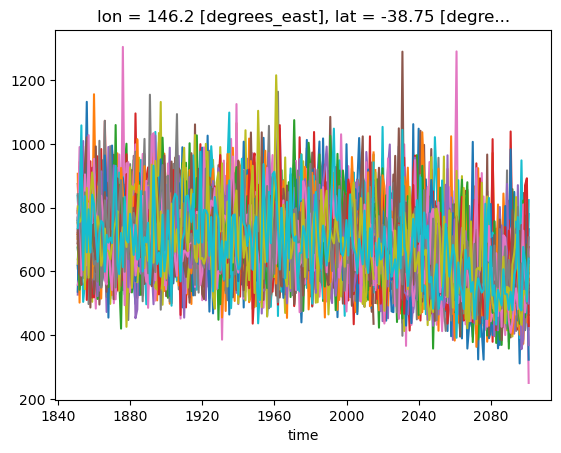

In [16]:
ssp585_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);
hist_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

In [17]:
hist_ds.time.dt.year.values[-1], ssp585_ds.time.dt.year.values[0]

(2014, 2015)

In [18]:
merged_ds = xr.concat([hist_ds, ssp585_ds], dim='time')

In [19]:
merged_ds = merged_ds.chunk({'time':-1, 'member':1, 'lat': 72//12, 'lon':144//12})
merged_ds = client.scatter(merged_ds).result().persist()
wait(merged_ds);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 6.12 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [24]:
merged_ds.name = 'pr'

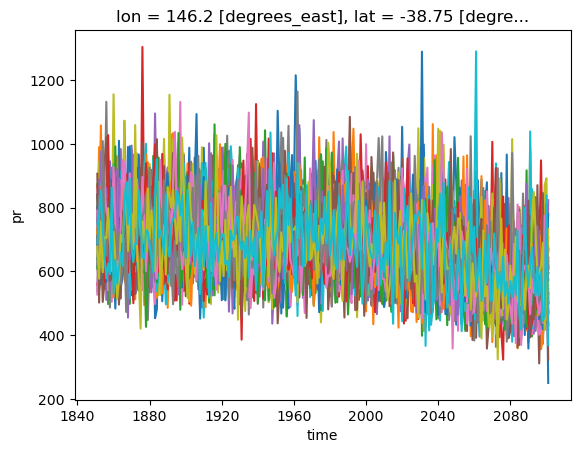

In [25]:
merged_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

In [26]:
model = 'access'

In [27]:
experiment = 'ssp585'

In [28]:
OUTPUT_FNAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}_{variable}.zarr'

In [29]:
OUTPUT_FNAME

'/g/data/w40/ab2313/time_of_emergence/access_ssp585_pr.zarr'

In [30]:
merged_ds.attrs['units'] = 'mm'

In [31]:
merged_ds

<xarray.DataArray 'pr' (member: 40, time: 251, lat: 72, lon: 144)> Size: 833MB
dask.array<rechunk-merge, shape=(40, 251, 72, 144), dtype=float64, chunksize=(1, 251, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes:
    units:    mm

In [32]:
merged_ds.to_zarr(OUTPUT_FNAME, mode='w')

In [76]:
merged_ds

<xarray.DataArray (member: 40, time: 251, lat: 72, lon: 144)> Size: 833MB
dask.array<rechunk-merge, shape=(40, 251, 72, 144), dtype=float64, chunksize=(1, 251, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes:
    units:    mm

## CESM1

In [6]:
def remove_duplicates_in_dim(ds, dim="member"):
    """
    Removes duplicate values in the specified coordinate (e.g., 'member') 
    while preserving only the first occurrence.

    Parameters:
    ds (xarray.Dataset): The input dataset with potentially duplicated coordinate values.
    dim (str): The coordinate to check for duplicates (default: "member").

    Returns:
    xarray.Dataset: A dataset with unique values in the specified coordinate.
    """
    if dim not in ds.coords:
        raise ValueError(f"Coordinate '{dim}' not found in dataset.")

    # Get coordinate values
    member_values = ds[dim].values

    # Find unique indices while keeping the first occurrence
    _, unique_indices = np.unique(member_values, return_index=True)

    # Select only unique members
    ds_unique = ds.isel({dim: np.sort(unique_indices)})

    return ds_unique

In [7]:
# model = 'canesm5_lens'
# experiment = 'ssp585'

model = 'cesm1_lens'
experiment = 'rcp85'

In [8]:
# LE_PATH = '/g/data/v45/nxm561/cesm2_lens/Amon/tas'
LE_PATH = f'/g/data/v45/nxm561/{model}/Amon/tas'

#'tas_Amon_CESM1-CAM5_historical_rcp45_r10i1p1_192001-208012_g025.nc')

In [9]:
os.listdir(LE_PATH)

['tas_Amon_CESM1-CAM5_historical_rcp85_r21i1p1_192001-210012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r26i1p1_192001-210012.nc',
 'tas_CESM1-CAM5_hist_rcp85_r32i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r15i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r11i1p1_192001-210012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r31i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r13i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r8i1p1_192001-210012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r23i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r34i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp85_r39i1p1_192001-210012_g025.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp45_r12i1p1_192001-208012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r37i1p1_192001-210012.nc',
 'tas_CESM1-CAM5_hist_rcp85_r1i1p1_192001-210012.nc',
 'tas_Amon_CESM1-CAM5_historical_rcp45_r13i1p1_192001-208012_g025.nc',
 'tas_CESM1-CAM5_hist_rcp85_r33i1

In [11]:
# file_list = glob(os.path.join(LE_PATH, '*rcp85*.nc'))
file_list = glob(os.path.join(LE_PATH, f'*{experiment}*.nc'))

In [12]:
len(file_list)

81

In [13]:
file_list[:-3]

['/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r21i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r26i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r32i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r15i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r11i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r31i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r13i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r8i1p1_192001-210012_g025.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_CESM1-CAM5_hist_rcp85_r23i1p1_192001-210012.nc',
 '/g/data/v45/nxm561/cesm1_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp

In [14]:
# Full paths
file_paths = [os.path.join(LE_PATH, f) for f in file_list]

# Regex to extract ensemble member (e.g., r21i1p1)
def extract_member(filename):
    match = re.search(r'r\d+i\d+p\d+', filename)
    return match.group(0) if match else None

# Open datasets individually, add member coordinate, and store them in a list
ds_list = []
for file in file_paths:
    member = extract_member(file)
    ds = xr.open_dataset(file) #, chunks='auto')#={'time':-1, 'lon':144//12, 'lat':72//12})
    ds = ds.assign_coords(member=member).expand_dims('member')
    ds_list.append(ds['tas'])

# Concatenate along the 'member' dimension
ds_combined = xr.concat(ds_list, dim='member').chunk(
    {'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

In [15]:
# ds_combined = ds_combined['tas']a

In [16]:
ds_combined

<xarray.DataArray 'tas' (member: 81, time: 3012, lat: 72, lon: 144)> Size: 20GB
dask.array<xarray-<this-array>, shape=(81, 3012, 72, 144), dtype=float64, chunksize=(81, 3012, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
    height   float64 8B 2.0
Attributes: (8)

In [17]:
ds_combined = ds_combined.drop_vars('height', errors='ignore')

In [18]:
ds_combined

<xarray.DataArray 'tas' (member: 81, time: 3012, lat: 72, lon: 144)> Size: 20GB
dask.array<xarray-<this-array>, shape=(81, 3012, 72, 144), dtype=float64, chunksize=(81, 3012, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 2kB 'r21i1p1' 'r26i1p1' ... 'r28i1p1' 'r40i1p1'
Attributes: (8)

In [19]:
ds_combined = remove_duplicates_in_dim(ds_combined, 'member')

In [20]:
ds_combined

<xarray.DataArray 'tas' (member: 40, time: 3012, lat: 72, lon: 144)> Size: 10GB
dask.array<getitem, shape=(40, 3012, 72, 144), dtype=float64, chunksize=(40, 3012, 6, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * member   (member) <U7 1kB 'r21i1p1' 'r26i1p1' ... 'r29i1p1' 'r22i1p1'
Attributes: (8)

In [21]:
ds_combined = client.scatter(ds_combined).result().persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 18.85 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [22]:
# ds_combined = ds_combined.chunk({'member': -1, 'time':-1, 'lon':144//12, 'lat':72//12}) 

In [23]:
# ds_combined = ds_combined.persist()
# wait(ds_combined)

In [24]:
ds_resamp_combined = ds_combined.resample(time='YE').mean()#.persist()
# wait(ds_resamp_combined)

In [25]:
ds_resamp_combined = client.scatter(ds_resamp_combined).result().persist()
wait(ds_resamp_combined)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 3, 1)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 10, 7)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 4, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 8, 10)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 4, 9)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 8, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 4, 10)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 8, 9)>, <Future: finished, type: numpy.ndarray, key: ('transpose-b329562b90dfa79b7e20bfbfd9b937b8', 0, 0, 2, 10)>, <Future: finis

In [26]:
OUTPUT_FNAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'

In [27]:
ds_resamp_combined.to_zarr(OUTPUT_FNAME, mode='w')

# ERA5

In [25]:
# np.array(os.listdir('/g/data/rt52/era5/single-levels'))
# np.array(os.listdir('/g/data/rt52/era5/single-levels/monthly-averaged'))

In [26]:
# client.cluster.scale(100)
# sleep(6)

In [27]:
# # #'2t': 2m tempeature
# # # 'tp': total precipitation
# # var = '2t'
# # rsn: snow density
# # sd: snow depth
# variable = 'sd'
# original_name = variable#'2t'
# base_path = f'/g/data/rt52/era5/single-levels/reanalysis'
# path = os.path.join(base_path, original_name)
# path

In [28]:
# MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
# output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
# output_file

In [29]:
# wild_tag = '*/*.nc'
# years = np.sort(os.listdir(path))
# files_to_open = np.array(glob(os.path.join(path, wild_tag), recursive=True))
# files_to_open.shape

In [30]:
# files_to_open[:2]

In [31]:
# td0 = xr.open_dataset(files_to_open[0])
# td = xr.open_dataset(files_to_open[-1])

In [32]:
# td[variable].attrs

In [33]:
# td0.sum(dim='time')[variable].plot()

In [34]:
# td.sum(dim='time')[variable].plot()

In [35]:
# climatology_files = np.array([
#     f for f in files_to_open 
#     if (
#         (year := int(f.split('/')[-2])) > base_period.start 
#         and year < base_period.end
#     )
# ])

In [36]:
# def __preprocess(ds):
#     return ds.to_array().rename({'latitude': 'lat', 'longitude': 'lon'})

In [37]:
# output_file_tmp = str(output_file).replace('.zarr', '_tmp.zarr')
# output_file_tmp

In [38]:
# clim_list = []
# for i, year in enumerate(np.arange(base_period.start, base_period.end)):
#     print(f'{year}, ', end='')
#     year_file = np.sort([f for f in files_to_open if str(year) in f.split('/')[-2]])
#     da_raw = xr.open_mfdataset(
#         year_file,
#         use_cftime=True,
#         chunks = CHUNKS_FOR_ERA5,
#         preprocess = __preprocess
#     )

#     # Annual averagte tempature
#     da = da_raw.resample(time="1D").mean()
    
#     da = da.squeeze("variable", drop=True)
#     da.name = original_name
#     clim_list.append(da)

In [39]:
# %%time
# base_period_ds = xr.concat(clim_list, dim='time').chunk(CHUNKS_FOR_ERA5)
# base_period_percentile_ds = base_period_ds.reduce(my_stats.dask_percentile, q=99.9, dim='time')
# base_period_percentile_ds = base_period_percentile_ds.persist()
# wait(base_period_percentile_ds)

In [40]:
# years_to_use = years #[years.astype(int) > 1981].astype(str)
# years_to_use

In [41]:
# for year in years_to_use: #years
#     print(f'{year}, ', end='')
#     year_file = np.sort([f for f in files_to_open if year in f.split('/')[-2]])
#     da_raw = xr.open_mfdataset(
#         year_file,
#         use_cftime=True,
#         chunks = chunks,
#         preprocess = __preprocess
#     )

#     # Annual averagte tempature OR mean snow density
#     # da = da_raw.resample(time='Y').mean().compute()

#     # Rx1d
#     # daily_resample = da_raw.resample(time="1D").sum()
#     # da = daily_resample.resample(time="1Y").max()

#     # Yearly total preci
#     # da = da_raw.resample(time='YE').sum()

#     # TX99Count
#     # daily_mean_da = da_raw.resample(time="1D").mean() # Daily mean tempeature
#     # da = (daily_mean_da > base_period_percentile_ds).resample(time='YE').sum()
#     #.groupby("time.year").sum()

#     da = da.chunk(chunks)
#     da = da.squeeze("variable", drop=True)
#     da.name = original_name
    
#     # # Save to Zarr
#     if year == years[0]:
#         # First year: Create the Zarr file
#         da.to_zarr(output_file_tmp, mode="w", consolidated=True)
#         print(f"Saved {year} to {output_file}")
#     else:
#         # Subsequent years: Append to the Zarr file
#         da.to_zarr(output_file_tmp, mode="a", append_dim="time")
#         print(f"Appended {year} to {output_file}")

In [42]:
# da.attrs

In [43]:
# (daily_mean_da > base_period_99p_ds).resample(time='YE').sum().compute().plot()

In [44]:
# output_file_tmp

In [45]:
# # Open all the files in the tmp file
# data_ds = (xr.open_zarr(output_file_tmp, use_cftime=True)
#            .to_array()
#            .compute()
#            .chunk(chunks=CHUNKS_FOR_ERA5))

In [46]:
# data_ds.time.dt.year

In [47]:
# data_ds = data_ds.squeeze('variable', drop=True)
# data_ds.name = variable

In [48]:
# data_ds = data_ds * 1000 # For precipitation

In [49]:
# data_ds.isel(time=16).plot(robust=True)

In [50]:
# data_ds.attrs = {
#     **data_ds.attrs,
#     "dataset_name": 'era5',
#     'variable': original_name,
#     'save_chunks' : CHUNKS_FOR_ERA5,
#     'info':("tp (total precipitation) reampled to daily"
#             "sum then resample to yearly max")
# }

In [51]:
# data_ds

In [52]:
# data_ds.to_zarr(output_file, mode='w')